# Fisher Transformation, Inverse Fisher and Cyber Cycle

In [32]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 7

In [33]:
# First import useful tools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [34]:
data = pd.read_csv('https://drive.google.com/uc?export=download&id=0B9-kA56h5JCMbXptY0kyVXZXaUU',
                 index_col=0, parse_dates=True)
time = data.index
price = data.CLOSE

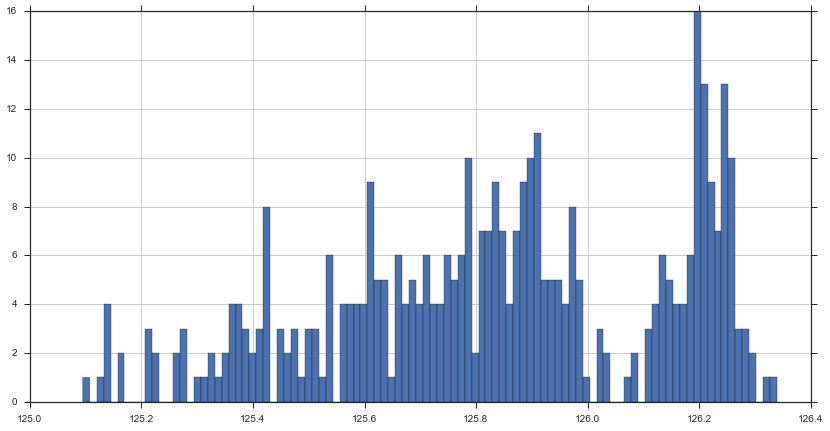

In [35]:
price.hist(bins=100)

In [36]:
def fisher(df, norm_window=20):
    # Normalize the price serie.
    df_norm = (df - pd.rolling_min(df, norm_window)) / (pd.rolling_max(df, norm_window) - \
                                                        pd.rolling_min(df, norm_window))
    # Center the serie on its midpoint and then doubled so that df_value
    # swings between −1 and +1.
    df_value = 2 * (df_norm - 0.5)
    # Smoothing df_value by applying EMA with alpha 0.5.
    df_value = 0.5 * df_value + 0.5 * df_value.shift()
    # Avoid division by zero and weird behavior.
    df_value[df_value < -0.999] = -0.999
    df_value[df_value > 0.999] = 0.999
    # Estimate the Fisher transform and smoothing again with an EMA with alpha 0.5.
    df_fisher = 0.5 * np.log((1 + df_value) / (1 - df_value))
    return 0.5 * df_fisher + 0.5 * df_fisher.shift()

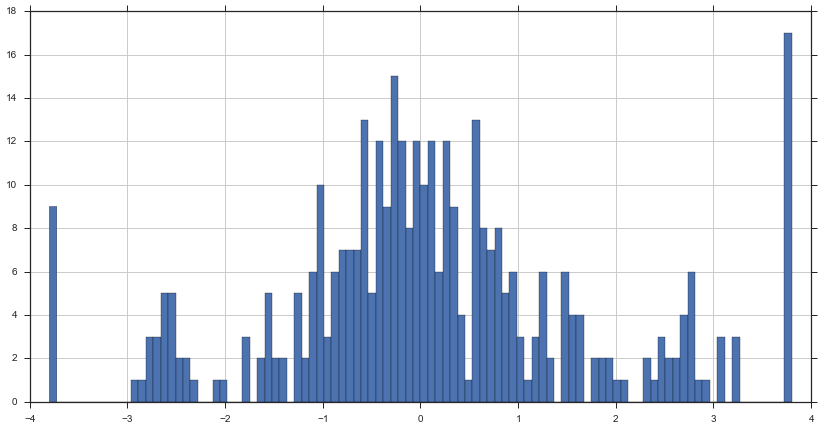

In [37]:
df_fisher = fisher(price)
df_fisher.hist(bins=100)

In [38]:
df_fisher_osc = pd.concat([df_fisher, df_fisher.shift()], axis=1)
df_fisher_osc.columns = ["Fisher", "Trigger"]

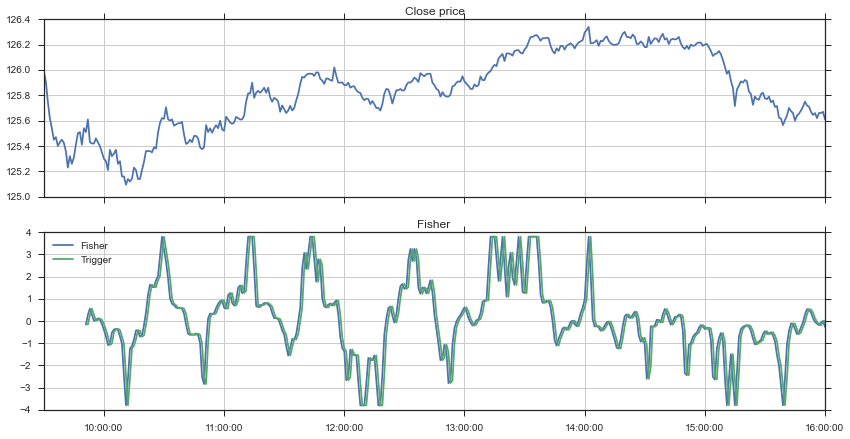

In [39]:
# Plotting.
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(time, data.CLOSE)
axarr[0].set_title('Close price')
axarr[0].grid()
axarr[1].plot(time, df_fisher_osc.Fisher, label='Fisher')
axarr[1].plot(time, df_fisher_osc.Trigger, label='Trigger')
axarr[1].legend(loc='upper left')
axarr[1].set_title('Fisher')
axarr[1].grid()

## Inverse Fisher Transform

In [40]:
def fisher_inverse(df, norm_window=20, normalization='statistical'):
    # Normalize the price serie.
    if normalization == 'channelling':
        df_norm = (df - pd.rolling_min(df, norm_window)) / \
                  (pd.rolling_max(df, norm_window) - pd.rolling_min(df, norm_window))
        # Center the serie on its midpoint and then doubled so that df_value
        # swings between −1 and +1.
        df_value = 2 * (df_norm - 0.5)
    elif normalization == 'statistical':
        df_value = 2 * (df - pd.rolling_mean(df, norm_window)) / \
                   pd.rolling_std(df, norm_window)
    # Avoid division by zero and weird behavior.
    df_value[df_value < -0.999] = -0.999
    df_value[df_value > 0.999] = 0.999
    df_inverse_fisher = (np.exp(2 * df_value) - 1) / (np.exp(2 * df_value) + 1)
    return df_inverse_fisher

In [41]:
def cyber_cycle(na_series):
    smooth = np.zeros(len(na_series)) 
    cycle = np.zeros(len(na_series))
    trigger = np.zeros(len(na_series))
    
    smooth[:3] = na_series[:3]
    
    for n in range(3, len(na_series)):
        smooth[n] = (na_series[n] + 2 * na_series[n-1] + 2 * na_series[n-2] + \
        na_series[n-3]) / 6
        if n < 10:
            cycle[n] = (na_series[n] - 2 * na_series[n-1] + na_series[n-2]) / 4
        else:
            cycle[n] = a_ * (smooth[n] - 2 * smooth[n-1] + smooth[n-2]) + \
                       2 * b_ * cycle[n-1] - (b_ ** 2) * cycle[n-2]
        trigger[n] = cycle[n-1]
    return list([cycle, trigger])

Let's estimate the Cyber Cycle of the price series and apply Fisher and Inverse Fisher to the Cyber Cyle indicator.

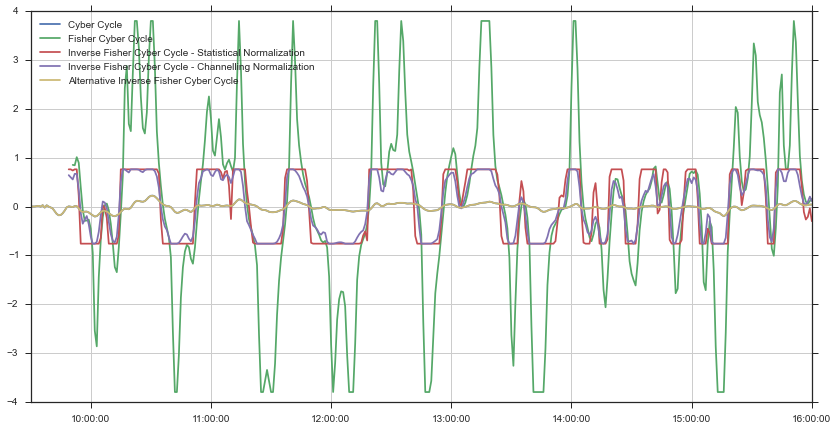

In [42]:
alpha = 0.07
a_ = (1 - 0.5 * alpha) ** 2
b_ = 1 - alpha

cycle, trigger = cyber_cycle(price)

FCC = fisher(pd.Series(cycle))
IFCC_1 = fisher_inverse(pd.Series(cycle), normalization='statistical')
IFCC_2 = fisher_inverse(pd.Series(cycle), normalization='channelling')

# Estimate an alternative Inverse Fisher without normalization.
alt_IFCC = df_inverse_fisher = (np.exp(2*cycle) - 1) / (np.exp(2*cycle) + 1)

plt.plot(time, cycle, label='Cyber Cycle')
plt.plot(time, FCC, label='Fisher Cyber Cycle')
plt.plot(time, IFCC_1, label='Inverse Fisher Cyber Cycle - Statistical Normalization')
plt.plot(time, IFCC_2, label='Inverse Fisher Cyber Cycle - Channelling Normalization')
plt.plot(time, alt_IFCC, label='Alternative Inverse Fisher Cyber Cycle')
plt.legend(loc='upper left')
plt.grid()

Seems that the Alternative Inverse Fisher Cyber Cycle wasn't plotted, however:

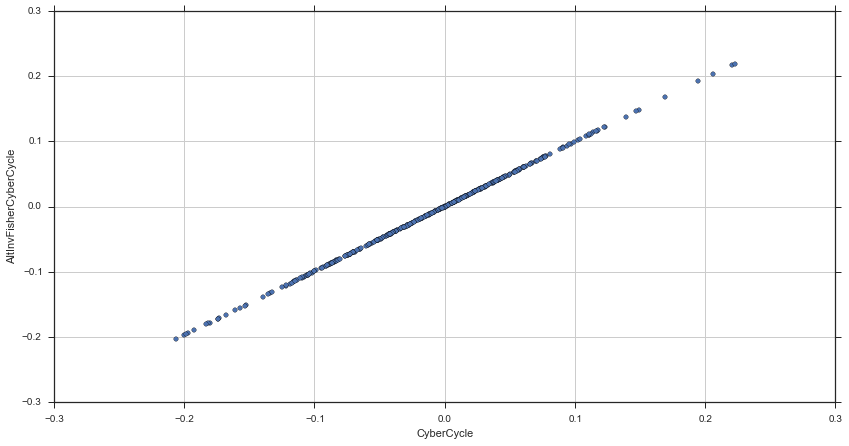

In [43]:
df = pd.DataFrame(np.transpose(np.vstack((price, cycle, trigger, FCC, IFCC_1, IFCC_2, alt_IFCC))),
                  index=data.index,
                  columns=['Price', 'CyberCycle', 'Trigger', 'FisherCyberCycle',
                           'InvFisherCyberCycleStatNorm', 'InvFisherCyberCycleChaNorm',
                           'AltInvFisherCyberCycle'])
df.plot(kind='scatter', x='CyberCycle', y='AltInvFisherCyberCycle', grid=True)

If the range around zero of the input series is too small, the inverse fisher function is almost lineal.

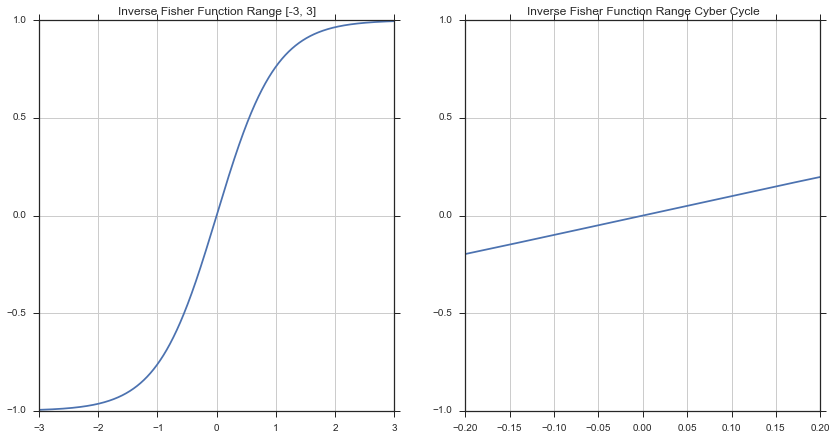

In [44]:
# E.g.
idx = np.arange(-3, 3, 0.001)
inv_fisher_function = (np.exp(2*idx) - 1) / (np.exp(2*idx) + 1)

# Plotting.
f, axarr = plt.subplots(1, 2)

axarr[0].plot(idx, inv_fisher_function)
axarr[0].set_title("Inverse Fisher Function Range [-3, 3]")
axarr[0].grid()
axarr[1].plot(idx, inv_fisher_function, label='Fisher')
axarr[1].set_title("Inverse Fisher Function Range Cyber Cycle")
axarr[1].set_xlim(xmin=round(min(cycle),1), xmax=round(max(cycle), 1))
axarr[1].grid()

#Signaling performance
##Cyber Cycle Oscilator

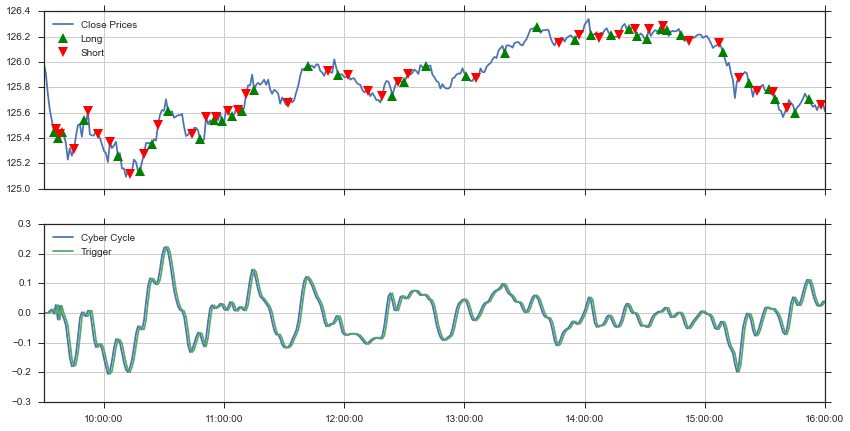

In [45]:
# Plotting
f, ax = plt.subplots(2, sharex=True)

threshold = 0.7
tol = 0.001

long_signal = (df.CyberCycle.shift() > df.Trigger.shift() + tol) & (df.CyberCycle < df.Trigger - tol)
short_signal = (df.CyberCycle.shift() < df.Trigger.shift() - tol) & (df.CyberCycle > df.Trigger + tol)

ax[0].plot(time, data.CLOSE, label='Close Prices')
ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].legend(loc='upper left')
ax[0].grid()

ax[1].plot(time, cycle, label='Cyber Cycle')
ax[1].plot(time, trigger, label='Trigger')
ax[1].legend(loc='upper left')
ax[1].grid()

##Fisher Cyber Cycle

In [46]:
def trigger_idx(pd_series, threshold, tol):
    cond_1 = (pd_series.shift() < threshold) & (pd_series > threshold + tol)
    cond_2 = (pd_series.shift() > threshold) & (pd_series < threshold - tol)

    cond_3 = (pd_series.shift() < -threshold) & (pd_series > -threshold + tol)
    cond_4 = (pd_series.shift() > -threshold) & (pd_series < -threshold - tol)
    return list([cond_1, cond_2, cond_3, cond_4])

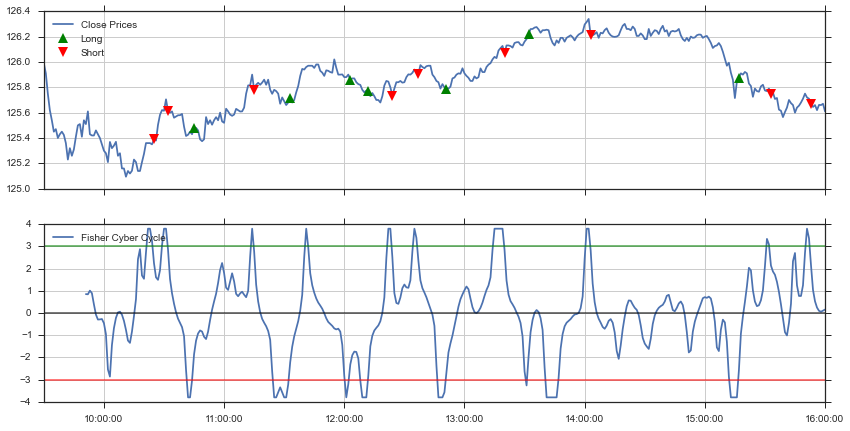

In [47]:
# Plotting
f, ax = plt.subplots(2, sharex=True)

threshold = 3 
signals = trigger_idx(df.FisherCyberCycle, threshold, 0.1)

long_signal = signals[2]
short_signal = signals[1]

ax[0].plot(time, data.CLOSE, label='Close Prices')
ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].legend(loc='upper left')
ax[0].grid()

ax[1].plot(time, df.FisherCyberCycle, label='Fisher Cyber Cycle')
ax[1].axhline(y=threshold, color='green', alpha=0.6)
ax[1].axhline(y=-threshold, color='red', alpha=0.6)
ax[1].axhline(y=0, color='black', alpha=0.6)
ax[1].legend(loc='upper left')
ax[1].grid()


##Inverse Fisher Cyber Cycle

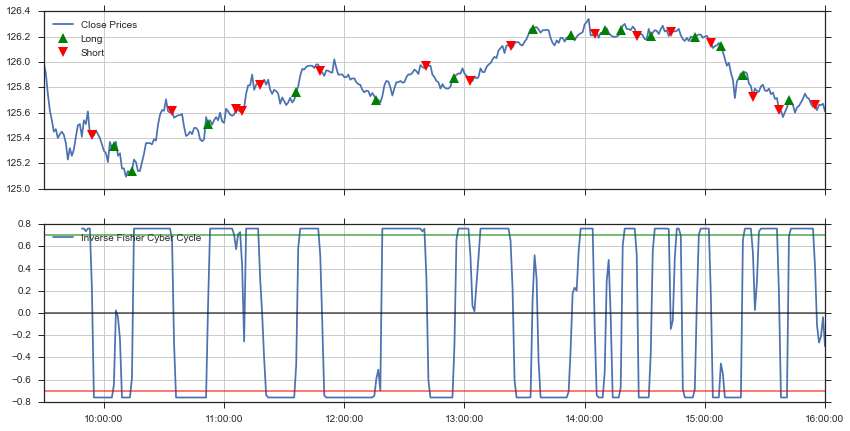

In [48]:
# Plotting
f, ax = plt.subplots(2, sharex=True)

threshold = 0.7 
signals = trigger_idx(df.InvFisherCyberCycleStatNorm, threshold, 0.01)

long_signal = signals[2]
short_signal = signals[1]

ax[0].plot(time, data.CLOSE, label='Close Prices')
ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].legend(loc='upper left')
ax[0].grid()

ax[1].plot(time, df.InvFisherCyberCycleStatNorm, label='Inverse Fisher Cyber Cycle')
ax[1].axhline(y=threshold, color='green', alpha=0.6)
ax[1].axhline(y=-threshold, color='red', alpha=0.6)
ax[1].axhline(y=0, color='black', alpha=0.6)
ax[1].legend(loc='upper left')
ax[1].grid()

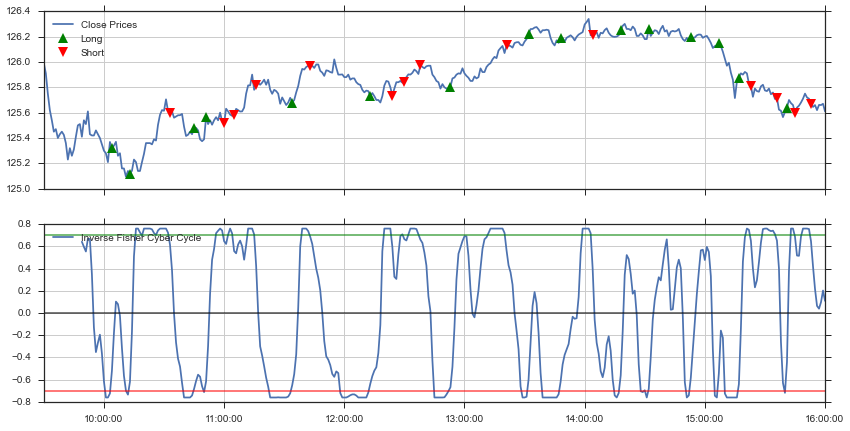

In [49]:
# Plotting
f, ax = plt.subplots(2, sharex=True)

threshold = 0.7 
signals = trigger_idx(df.InvFisherCyberCycleChaNorm, threshold, 0.01)

long_signal = signals[2]
short_signal = signals[1]

ax[0].plot(time, data.CLOSE, label='Close Prices')
ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].legend(loc='upper left')
ax[0].grid()

ax[1].plot(time, df.InvFisherCyberCycleChaNorm, label='Inverse Fisher Cyber Cycle')
ax[1].axhline(y=threshold, color='green', alpha=0.6)
ax[1].axhline(y=-threshold, color='red', alpha=0.6)
ax[1].axhline(y=0, color='black', alpha=0.6)
ax[1].legend(loc='upper left')
ax[1].grid()